## 🌫️ Training Pipeline for Global CO₂

This notebook trains a model to predict global CO₂ concentration using historical features.

### Sections:
1. Select features and create Feature View
2. Create training data using the feature view
3. Train model (trend + residual ensemble)
4. Evaluate model performance
5. Save model to model registry


### Imports


In [1]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import hopsworks
import os
import warnings
from dotenv import load_dotenv
import numpy as np

load_dotenv()

api_key = os.getenv("HOPSWORKS_API_KEY")

project = hopsworks.login(host="eu-west.cloud.hopsworks.ai",
project="EarthTamagotchi", api_key_value=api_key)
fs = project.get_feature_store()

warnings.filterwarnings("ignore")


2026-01-03 13:27:52,005 INFO: Initializing external client
2026-01-03 13:27:52,005 INFO: Base URL: https://eu-west.cloud.hopsworks.ai:443
2026-01-03 13:27:53,313 INFO: Python Engine initialized.

Logged in to project, explore it here https://eu-west.cloud.hopsworks.ai:443/p/2177


## Connect to Hopsworks Feature Store


In [2]:
# Retrieve feature group
# Try version 1 first (as per previous working state), fallback to latest if needed
try:
    co2_fg = fs.get_feature_group(
        name='global_co2',
        version=1,
    )
    if co2_fg is None:
        # If version 2 doesn't exist, try latest version
        co2_fg = fs.get_feature_group(name='global_co2')
except:
    # Fallback to latest version
    co2_fg = fs.get_feature_group(name='global_co2')

if co2_fg is None:
    raise ValueError("Could not retrieve 'global_co2' feature group. Please check if it exists in Hopsworks.")

print(f"Retrieved feature group: {co2_fg.name}, version: {co2_fg.version}")


Retrieved feature group: global_co2, version: 1


## Feature View Creation


In [ ]:
# Select features for training data
# We'll predict 'average' (CO2 concentration) using historical features

# All time-based features are created in the feature pipelines and stored in the feature group
selected_features = co2_fg.select([
    'date',
    'average', # This will be our target/label (automatically excluded from X_train)
    # Historical average features
    'average_lag_1',
    'average_lag_2',
    'average_lag_3',
    'average_lag_6',
    'average_lag_12',
    'average_roll_3',   # 3-month rolling mean of past averages
    'average_roll_12',  # 12-month rolling mean of past averages
    # Historical trend features (these are fine, they're past values)
    'trend_lag_1',
    'trend_lag_2',
    'trend_lag_3',
    'trend_lag_6',
    'trend_lag_12',
    'trend_roll_3',   # 3-month rolling mean of past trends
    'trend_roll_12',  # 12-month rolling mean of past trends
    # Time-based features (created in feature pipelines)
    'year',
    'month',
    'month_sin',
    'month_cos',
    'year_normalized',
    'year_normalized_squared',
    'year_month_sin',  # Interaction term: captures evolving seasonality
    'year_month_cos',  # Interaction term: captures evolving seasonality
])


### About Feature Views

Feature Views are selections of features from different Feature Groups that make up the input and output API for a model. They can create Training Data and be used in Inference to retrieve inference data.


In [4]:
feature_view = fs.get_or_create_feature_view(
    name='co2_fv',    
    description="CO2 features with average CO2 concentration as the target. Time-based features are created locally in training pipeline.",    
    version=1, 
    labels=['average'],    
    query=selected_features,
)

## Split Training Data into Train/Test Sets

We use a time-series split: training data before `start_date_test_data` and test data after this date.


In [5]:
# Use a date that splits the data into train/test
start_date_test_data = "2019-01-01"
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [6]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.11s) 
2026-01-03 13:28:01,897 INFO: Computing insert statistics
2026-01-03 13:28:01,971 INFO: Computing insert statistics


In [7]:
X_train.head()

,date,average_lag_1,average_lag_2,average_lag_3,average_lag_6,average_lag_12,average_roll_3,average_roll_12,trend_lag_1,trend_lag_2,...,trend_roll_3,trend_roll_12,year,month,month_sin,month_cos,year_normalized,year_normalized_squared,year_month_sin,year_month_cos
131,1970-02-01,325.059998,324.109985,322.850006,323.660004,324.410004,324.006663,324.709167,325.010010,324.910004,...,324.906667,324.704999,1970,2,8.660254e-01,5.000000e-01,0.166667,0.027778,1.443376e-01,8.333333e-02
132,1970-03-01,325.989990,325.059998,324.109985,322.380005,325.630005,325.053324,324.840833,325.309998,325.010010,...,325.076670,324.834999,1970,3,1.000000e+00,6.123234e-17,0.166667,0.027778,1.666667e-01,1.020539e-17
133,1970-04-01,326.929993,325.989990,325.059998,321.779999,326.660004,325.993327,324.949165,325.609985,325.309998,...,325.309998,324.943331,1970,4,8.660254e-01,-5.000000e-01,0.166667,0.027778,1.443376e-01,-8.333333e-02
134,1970-05-01,328.130005,326.929993,325.989990,322.850006,327.380005,327.016663,325.071665,325.750000,325.609985,...,325.556661,325.065832,1970,5,5.000000e-01,-8.660254e-01,0.166667,0.027778,8.333333e-02,-1.443376e-01
135,1970-06-01,328.079987,328.130005,326.929993,324.109985,326.709991,327.713328,325.129997,325.149994,325.750000,...,325.503326,325.123332,1970,6,1.224647e-16,-1.000000e+00,0.166667,0.027778,2.041078e-17,-1.666667e-01


In [8]:
# All time-based features are already created in the feature pipelines
# We just need to drop the date column since we have all the features we need
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

X_features.head()

,average_lag_1,average_lag_2,average_lag_3,average_lag_6,average_lag_12,average_roll_3,average_roll_12,trend_lag_1,trend_lag_2,trend_lag_3,...,trend_roll_3,trend_roll_12,year,month,month_sin,month_cos,year_normalized,year_normalized_squared,year_month_sin,year_month_cos
131,325.059998,324.109985,322.850006,323.660004,324.410004,324.006663,324.709167,325.010010,324.910004,324.799988,...,324.906667,324.704999,1970,2,8.660254e-01,5.000000e-01,0.166667,0.027778,1.443376e-01,8.333333e-02
132,325.989990,325.059998,324.109985,322.380005,325.630005,325.053324,324.840833,325.309998,325.010010,324.910004,...,325.076670,324.834999,1970,3,1.000000e+00,6.123234e-17,0.166667,0.027778,1.666667e-01,1.020539e-17
133,326.929993,325.989990,325.059998,321.779999,326.660004,325.993327,324.949165,325.609985,325.309998,325.010010,...,325.309998,324.943331,1970,4,8.660254e-01,-5.000000e-01,0.166667,0.027778,1.443376e-01,-8.333333e-02
134,328.130005,326.929993,325.989990,322.850006,327.380005,327.016663,325.071665,325.750000,325.609985,325.309998,...,325.556661,325.065832,1970,5,5.000000e-01,-8.660254e-01,0.166667,0.027778,8.333333e-02,-1.443376e-01
135,328.079987,328.130005,326.929993,324.109985,326.709991,327.713328,325.129997,325.149994,325.750000,325.609985,...,325.503326,325.123332,1970,6,1.224647e-16,-1.000000e+00,0.166667,0.027778,2.041078e-17,-1.666667e-01


In [9]:
y_train.head()

,average
131,325.989990
132,326.929993
133,328.130005
134,328.079987
135,327.670013


## Modeling

We train a two-stage model:
1. **Trend model**: Linear regression on time features (year, seasonality, interactions)
2. **Residual model**: Gradient Boosting on lag and rolling features


In [10]:
# Ensure y_train and y_test are 1D arrays/Series
if hasattr(y_train, 'iloc'):
    y_train = y_train.iloc[:, 0] if y_train.ndim > 1 else y_train
if hasattr(y_test, 'iloc'):
    y_test = y_test.iloc[:, 0] if y_test.ndim > 1 else y_test

# Trend + Residual Modeling 
# 1) Enhanced linear trend model (year trend + seasonality + interactions)
# Includes polynomial year terms to capture acceleration in CO2 increase
trend_features = ['year_normalized', 'year_normalized_squared', 'month_sin', 'month_cos', 'year_month_sin', 'year_month_cos', 'month', 'year']
X_trend_train = X_features[trend_features]
X_trend_test = X_test_features[trend_features]

trend_model = LinearRegression()
trend_model.fit(X_trend_train, y_train)
y_trend_train = trend_model.predict(X_trend_train)


# 2) Residual model using Gradient Boosting
# Remove trend features since trend model already captures long-term trend and seasonality
residual_features_to_remove = ['year', 'month', 'year_normalized', 'year_normalized_squared', 'month_sin', 'month_cos', 'year_month_sin', 'year_month_cos']
X_features_residual = X_features.drop(columns=[col for col in residual_features_to_remove if col in X_features.columns])
X_test_features_residual = X_test_features.drop(columns=[col for col in residual_features_to_remove if col in X_test_features.columns])

residual_train = y_train - y_trend_train

# Train Gradient Boosting residual model
residual_model_gb = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=4,
    subsample=0.8,
    random_state=42,
    loss='squared_error'
)

residual_model_gb.fit(X_features_residual, residual_train)

# Calculate bias correction based on GB residuals only
residual_pred_train_gb = residual_model_gb.predict(X_features_residual)
bias_correction = (residual_train - residual_pred_train_gb).mean()

In [11]:
# Predictions: trend + GB residuals + bias correction
y_trend_test = trend_model.predict(X_trend_test)
residual_pred_gb = residual_model_gb.predict(X_test_features_residual)
y_pred = y_trend_test + residual_pred_gb + bias_correction

# Calculate metrics
y_test_flat = y_test.iloc[:, 0] if hasattr(y_test, 'iloc') and y_test.ndim > 1 else y_test
mse = mean_squared_error(y_test_flat, y_pred)
r2 = r2_score(y_test_flat, y_pred)
mae = mean_absolute_error(y_test_flat, y_pred)

print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")


MSE: 1.1282
R²: 0.9621
MAE: 0.8445


In [12]:
# Create comparison dataframe
df = pd.DataFrame({
    'average': y_test_flat,
    'predicted_average': y_pred,
    'date': pd.to_datetime(X_test['date'].iloc[:len(y_pred)])
})
df = df.sort_values(by='date').reset_index(drop=True)
df.head(10)


,average,predicted_average,date
0,411.029999,410.099698,2019-01-01
1,411.959991,411.998385,2019-02-01
2,412.179993,413.284682,2019-03-01
3,413.540009,413.902702,2019-04-01
4,414.859985,413.750454,2019-05-01
5,414.149994,412.804151,2019-06-01
6,411.959991,411.544965,2019-07-01
7,410.170013,410.100603,2019-08-01
8,408.760010,409.134855,2019-09-01
9,408.739990,408.728555,2019-10-01


In [13]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "co2_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)


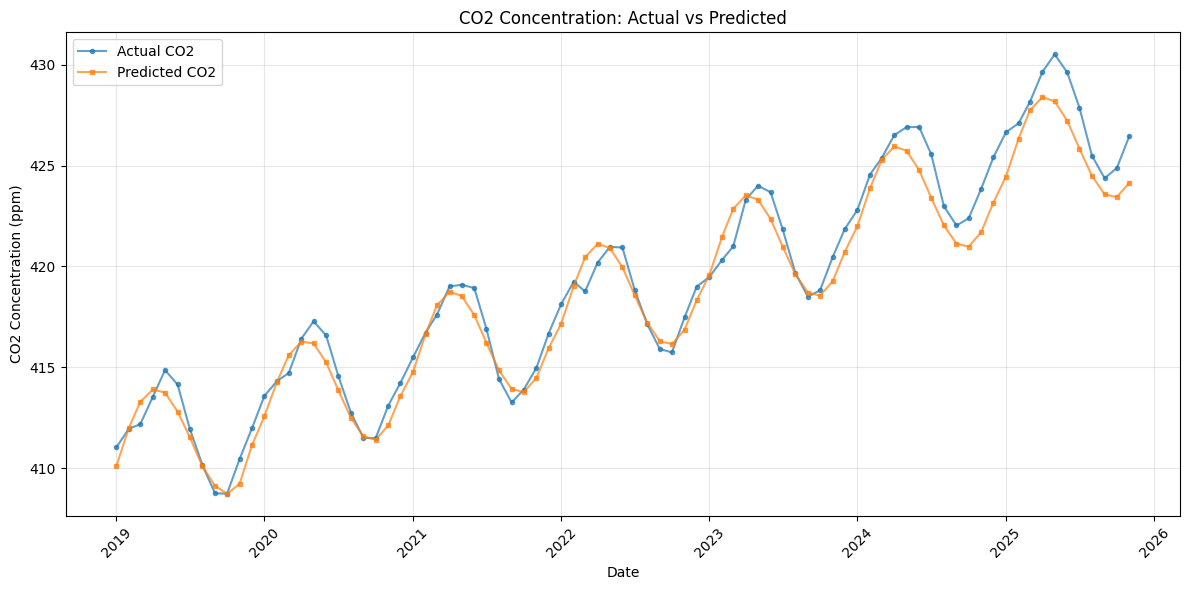

In [14]:
# Plot actual vs predicted CO2
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['average'], label='Actual CO2', alpha=0.7, marker='o', markersize=3)
plt.plot(df['date'], df['predicted_average'], label='Predicted CO2', alpha=0.7, marker='s', markersize=3)
plt.xlabel('Date')
plt.ylabel('CO2 Concentration (ppm)')
plt.title('CO2 Concentration: Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

file_path = images_dir + "/co2_hindcast.png"
plt.savefig(file_path, dpi=150, bbox_inches='tight')
plt.show()


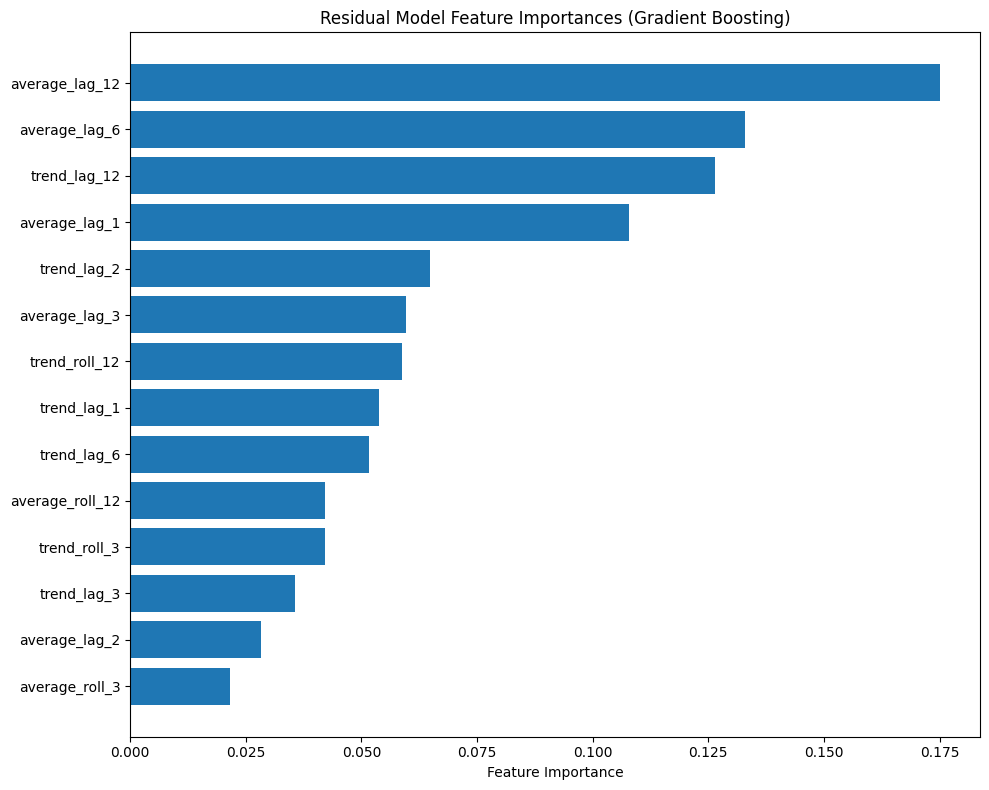


Top 10 most important features:
            feature  importance
4    average_lag_12    0.174981
3     average_lag_6    0.132989
11     trend_lag_12    0.126344
0     average_lag_1    0.107764
8       trend_lag_2    0.064715
2     average_lag_3    0.059584
13    trend_roll_12    0.058691
7       trend_lag_1    0.053716
10      trend_lag_6    0.051696
6   average_roll_12    0.042124


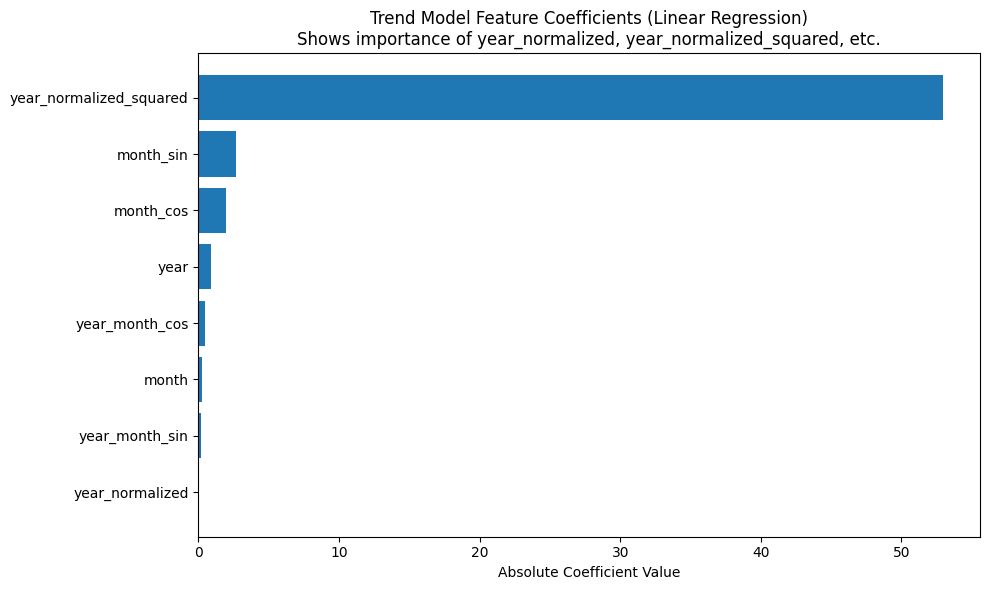


=== TREND MODEL COEFFICIENTS (shows importance of year features) ===
                   feature  coefficient  abs_coefficient
1  year_normalized_squared    52.940275        52.940275
2                month_sin     2.689322         2.689322
3                month_cos    -1.990985         1.990985
7                     year     0.857991         0.857991
5           year_month_cos     0.428766         0.428766
6                    month     0.254137         0.254137
4           year_month_sin     0.154657         0.154657
0          year_normalized     0.013000         0.013000

=== RESIDUAL MODEL FEATURE IMPORTANCES (Top 10) ===
            feature  importance
4    average_lag_12    0.174981
3     average_lag_6    0.132989
11     trend_lag_12    0.126344
0     average_lag_1    0.107764
8       trend_lag_2    0.064715
2     average_lag_3    0.059584
13    trend_roll_12    0.058691
7       trend_lag_1    0.053716
10      trend_lag_6    0.051696
6   average_roll_12    0.042124

Note: year_

In [15]:
# Plotting feature importances for residual model (Gradient Boosting)
feature_importances = pd.DataFrame({
    'feature': X_features_residual.columns,
    'importance': residual_model_gb.feature_importances_,
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importances)), feature_importances['importance'])
plt.yticks(range(len(feature_importances)), feature_importances['feature'])
plt.xlabel('Feature Importance')
plt.title('Residual Model Feature Importances (Gradient Boosting)')
plt.gca().invert_yaxis()
plt.tight_layout()

feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path, dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 10 most important features:")
print(feature_importances.head(10))

# Also show trend model coefficients (absolute values as importance)
# This shows how important year_normalized and year_normalized_squared are in the trend model
trend_coefficients = pd.DataFrame({
    'feature': trend_features,
    'coefficient': trend_model.coef_,
    'abs_coefficient': np.abs(trend_model.coef_)
}).sort_values('abs_coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(range(len(trend_coefficients)), trend_coefficients['abs_coefficient'])
plt.yticks(range(len(trend_coefficients)), trend_coefficients['feature'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Trend Model Feature Coefficients (Linear Regression)\nShows importance of year_normalized, year_normalized_squared, etc.')
plt.gca().invert_yaxis()
plt.tight_layout()

trend_coef_path = images_dir + "/trend_model_coefficients.png"
plt.savefig(trend_coef_path, dpi=150, bbox_inches='tight')
plt.show()

print("\n=== TREND MODEL COEFFICIENTS (shows importance of year features) ===")
print(trend_coefficients)
print("\n=== RESIDUAL MODEL FEATURE IMPORTANCES (Top 10) ===")
print(feature_importances.head(10))
print("\nNote: year_normalized and year_normalized_squared are used in the TREND model,")
print("so their importance shows up in the trend coefficients above, not in residual importances.")


## Model Registry

Save the trained model to Hopsworks model registry for versioning and deployment.


In [16]:
# Save models and parameters
joblib.dump(trend_model, model_dir + "/trend_model.pkl")
joblib.dump(residual_model_gb, model_dir + "/residual_model_gb.pkl")
joblib.dump({
    'bias_correction': bias_correction
}, model_dir + "/normalization_params.pkl")
print("Models and parameters saved successfully.")


Models and parameters saved successfully.


In [17]:
# Hopsworks model metrics must be numeric (castable to float), so we only store numeric values here.
res_dict = { 
    "MSE": float(mse),
    "R squared": float(r2),
    "MAE": float(mae),
    "BiasCorrection": float(bias_correction),
}

# Model architecture description is passed via the `description` field when creating the model
model_description = "EnhancedLinearTrend + GBResidual + BiasCorrection"


In [18]:
mr = project.get_model_registry()

# Creating a Python model in the model registry
model_name = "co2_trend_residual_model"
print(f"Creating model: {model_name}")

co2_model = mr.python.create_model(
    name=model_name, 
    metrics=res_dict,
    feature_view=feature_view,
    description=f"Global CO2 concentration predictor using {model_description}",
)

# Saving the model artifacts to the 'co2_model' directory in the model registry
co2_model.save(model_dir)


Creating model: co2_trend_residual_model


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/datskiw/KTH/ID2223/project/atwEarthTamagotchi/notebooks/co2_model/trend_model.pkl: 0.000%|   …

Uploading /Users/datskiw/KTH/ID2223/project/atwEarthTamagotchi/notebooks/co2_model/normalization_params.pkl: 0…

Uploading /Users/datskiw/KTH/ID2223/project/atwEarthTamagotchi/notebooks/co2_model/residual_model_gb.pkl: 0.00…

Uploading /Users/datskiw/KTH/ID2223/project/atwEarthTamagotchi/notebooks/co2_model/images/feature_importance.p…

Uploading /Users/datskiw/KTH/ID2223/project/atwEarthTamagotchi/notebooks/co2_model/images/trend_model_coeffici…

Uploading /Users/datskiw/KTH/ID2223/project/atwEarthTamagotchi/notebooks/co2_model/images/co2_hindcast.png: 0.…

Uploading /Users/datskiw/KTH/ID2223/project/atwEarthTamagotchi/notebooks/model_schema.json: 0.000%|          |…

Model created, explore it at https://eu-west.cloud.hopsworks.ai:443/p/2177/models/co2_trend_residual_model/3


Model(name: 'co2_trend_residual_model', version: 3)

## 🌡️ Temperature Training Pipeline

In [19]:
# Retrieve temperature feature group
try:
    temp_fg = fs.get_feature_group(
        name="global_temperature",
        version=1,
    )
    if temp_fg is None:
        temp_fg = fs.get_feature_group(name="global_temperature")
except:
    temp_fg = fs.get_feature_group(name="global_temperature")

if temp_fg is None:
    raise ValueError("Could not retrieve 'global_temperature' feature group. Please check if it exists in Hopsworks.")

print(f"Retrieved temperature feature group: {temp_fg.name}, version: {temp_fg.version}")


Retrieved temperature feature group: global_temperature, version: 1


In [20]:
# Build Feature View for temperature

# Select features for training data
# Target: temp_anomaly
# Features: lagged/rolling temperature anomaly + time-based features (year, month, seasonality)

temp_selected_features = temp_fg.select([
    'date',
    'temp_anomaly',             # target
    # Lag and rolling features
    'temp_anomaly_lag_1',
    'temp_anomaly_lag_2',
    'temp_anomaly_lag_3',
    'temp_anomaly_lag_6',
    'temp_anomaly_lag_12',
    'temp_anomaly_roll_3',
    'temp_anomaly_roll_12',
    # Time-based features
    'year',
    'month',
    'month_sin',
    'month_cos',
    'year_normalized',
    'year_normalized_squared',
    'year_month_sin',
    'year_month_cos',
])

# Create or get temperature feature view
temp_feature_view = fs.get_or_create_feature_view(
    name='temperature_fv',
    description='Global temperature anomaly features with lags, rolling means, and time-based features for trend modeling',
    version=1,
    labels=['temp_anomaly'],
    query=temp_selected_features,
)

# Time-based split (align with CO₂ split date for comparability)
start_date_test_temp = "2019-01-01"
temp_test_start = datetime.strptime(start_date_test_temp, "%Y-%m-%d")

X_temp_train, X_temp_test, y_temp_train, y_temp_test = temp_feature_view.train_test_split(
    test_start=temp_test_start
)

X_temp_train.head()


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.23s) 
2026-01-03 13:28:40,832 INFO: Computing insert statistics
2026-01-03 13:28:40,852 INFO: Computing insert statistics


,date,temp_anomaly_lag_1,temp_anomaly_lag_2,temp_anomaly_lag_3,temp_anomaly_lag_6,temp_anomaly_lag_12,temp_anomaly_roll_3,temp_anomaly_roll_12,year,month,month_sin,month_cos,year_normalized,year_normalized_squared,year_month_sin,year_month_cos
1069,1970-02-01,0.08,0.24,0.12,0.04,-0.18,0.146667,0.068333,1970,2,8.660254e-01,5.000000e-01,0.618056,0.381993,5.352518e-01,3.090278e-01
1070,1970-03-01,0.22,0.08,0.24,0.08,0.01,0.180000,0.101667,1970,3,1.000000e+00,6.123234e-17,0.618056,0.381993,6.180556e-01,3.784499e-17
1071,1970-04-01,0.06,0.22,0.08,0.09,0.17,0.120000,0.105833,1970,4,8.660254e-01,-5.000000e-01,0.618056,0.381993,5.352518e-01,-3.090278e-01
1072,1970-05-01,0.05,0.06,0.22,0.12,0.18,0.110000,0.095833,1970,5,5.000000e-01,-8.660254e-01,0.618056,0.381993,3.090278e-01,-5.352518e-01
1073,1970-06-01,-0.03,0.05,0.06,0.24,0.03,0.026667,0.078333,1970,6,1.224647e-16,-1.000000e+00,0.618056,0.381993,7.568998e-17,-6.180556e-01


In [21]:
# Drop date from features
X_temp_features_train = X_temp_train.drop(columns=['date'])
X_temp_features_test = X_temp_test.drop(columns=['date'])

# Ensure y is 1D
if hasattr(y_temp_train, 'iloc'):
    y_temp_train = y_temp_train.iloc[:, 0] if y_temp_train.ndim > 1 else y_temp_train
if hasattr(y_temp_test, 'iloc'):
    y_temp_test = y_temp_test.iloc[:, 0] if y_temp_test.ndim > 1 else y_temp_test

# Trend + Residual Modeling for Temperature 
# 1) Linear trend model on time features
trend_temp_features = ['year_normalized', 'year_normalized_squared', 'month_sin', 'month_cos', 'year_month_sin', 'year_month_cos']
X_temp_trend_train = X_temp_features_train[trend_temp_features]
X_temp_trend_test = X_temp_features_test[trend_temp_features]

trend_temp_model = LinearRegression()
trend_temp_model.fit(X_temp_trend_train, y_temp_train)
y_temp_trend_train = trend_temp_model.predict(X_temp_trend_train)

# 2) Residual model using Gradient Boosting (on lag/roll features only)
residual_temp_features_to_remove = ['year', 'month', 'year_normalized', 'year_normalized_squared', 'month_sin', 'month_cos', 'year_month_sin', 'year_month_cos']
X_temp_residual_train = X_temp_features_train.drop(columns=[c for c in residual_temp_features_to_remove if c in X_temp_features_train.columns])
X_temp_residual_test = X_temp_features_test.drop(columns=[c for c in residual_temp_features_to_remove if c in X_temp_features_test.columns])

residual_temp_train = y_temp_train - y_temp_trend_train

residual_temp_model_gb = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=4,
    subsample=0.8,
    random_state=42,
    loss='squared_error'
)

residual_temp_model_gb.fit(X_temp_residual_train, residual_temp_train)

# Bias correction for temperature residuals
residual_temp_pred_train_gb = residual_temp_model_gb.predict(X_temp_residual_train)
_bias_correction_temp = (residual_temp_train - residual_temp_pred_train_gb).mean()

# Predictions on test set
y_temp_trend_test = trend_temp_model.predict(X_temp_trend_test)
residual_temp_pred_test = residual_temp_model_gb.predict(X_temp_residual_test)
y_temp_pred = y_temp_trend_test + residual_temp_pred_test + _bias_correction_temp

mse_temp = mean_squared_error(y_temp_test, y_temp_pred)
r2_temp = r2_score(y_temp_test, y_temp_pred)
mae_temp = mean_absolute_error(y_temp_test, y_temp_pred)

print("Temperature model - Trend + GB residual")
print(f"MSE: {mse_temp:.4f}")
print(f"R²: {r2_temp:.4f}")
print(f"MAE: {mae_temp:.4f}")


Temperature model - Trend + GB residual
MSE: 0.0201
R²: 0.4588
MAE: 0.1084


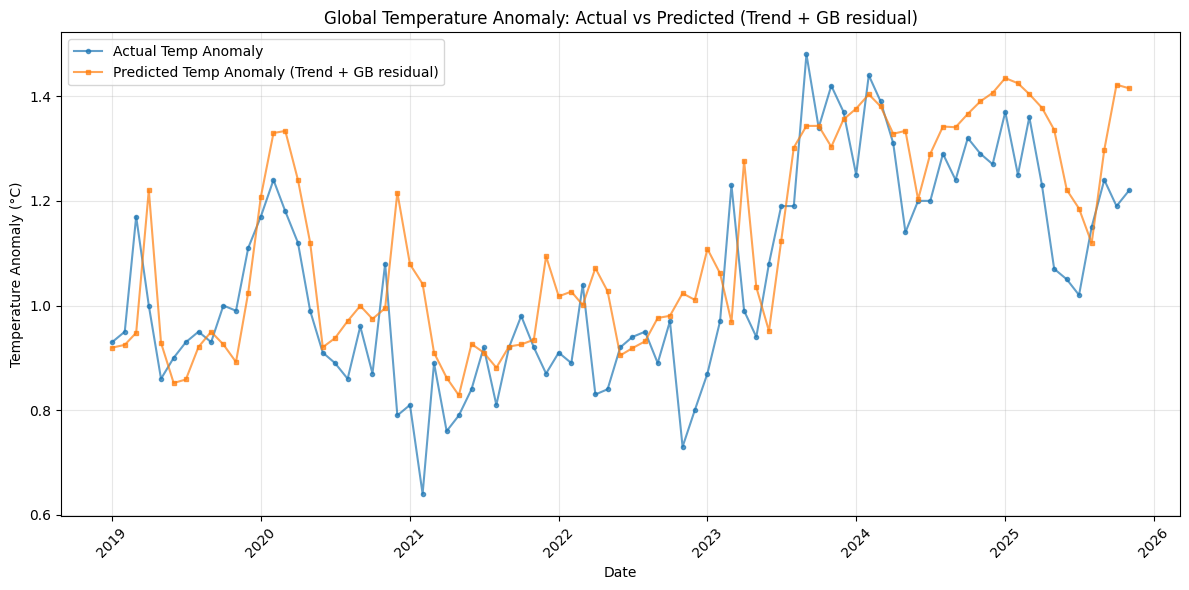

In [22]:
# Plot actual vs predicted temperature anomaly (Trend + GB residual)
temp_df_eval = pd.DataFrame({
    'temp_anomaly': y_temp_test,
    'predicted_temp_anomaly': y_temp_pred,
    'date': pd.to_datetime(X_temp_test['date'].iloc[:len(y_temp_pred)])
}).sort_values('date').reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(temp_df_eval['date'], temp_df_eval['temp_anomaly'], label='Actual Temp Anomaly', alpha=0.7, marker='o', markersize=3)
plt.plot(temp_df_eval['date'], temp_df_eval['predicted_temp_anomaly'], label='Predicted Temp Anomaly (Trend + GB residual)', alpha=0.7, marker='s', markersize=3)
plt.xlabel('Date')
plt.ylabel('Temperature Anomaly (°C)')
plt.title('Global Temperature Anomaly: Actual vs Predicted (Trend + GB residual)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

if not os.path.exists('temp_model'):
    os.mkdir('temp_model')
if not os.path.exists('temp_model/images'):
    os.mkdir('temp_model/images')

plt.savefig('temp_model/images/temp_hindcast.png', dpi=150, bbox_inches='tight')
plt.show()


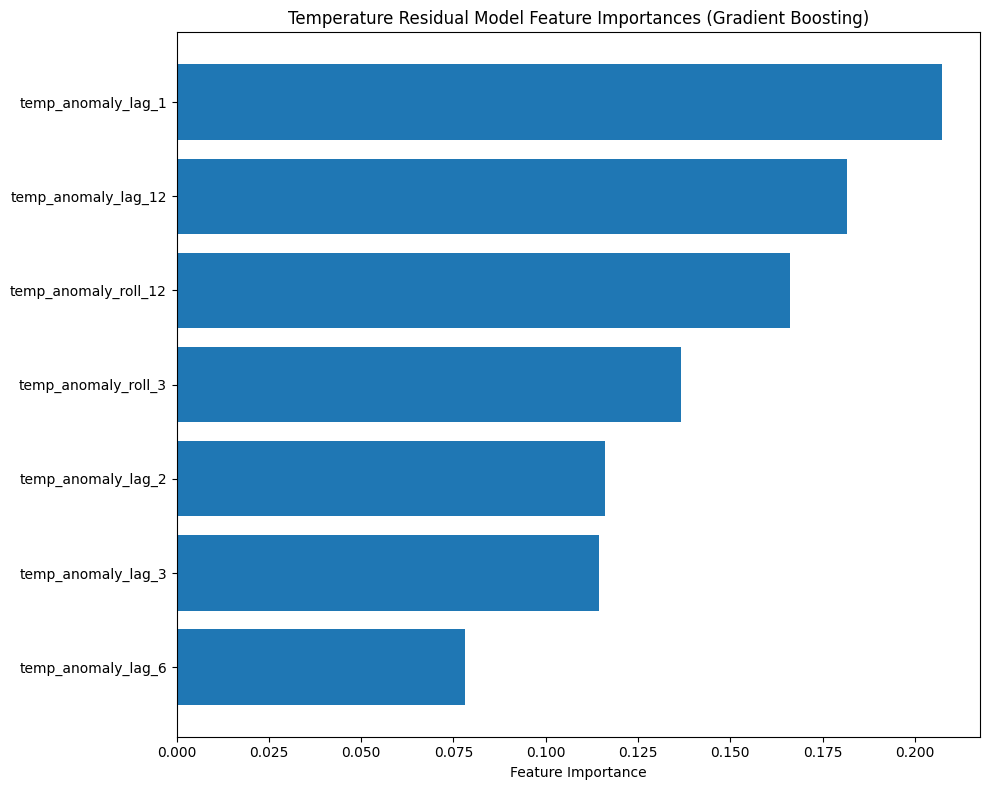


Top 10 most important temperature residual features:
                feature  importance
0    temp_anomaly_lag_1    0.207269
4   temp_anomaly_lag_12    0.181639
6  temp_anomaly_roll_12    0.166157
5   temp_anomaly_roll_3    0.136681
1    temp_anomaly_lag_2    0.115921
2    temp_anomaly_lag_3    0.114326
3    temp_anomaly_lag_6    0.078007


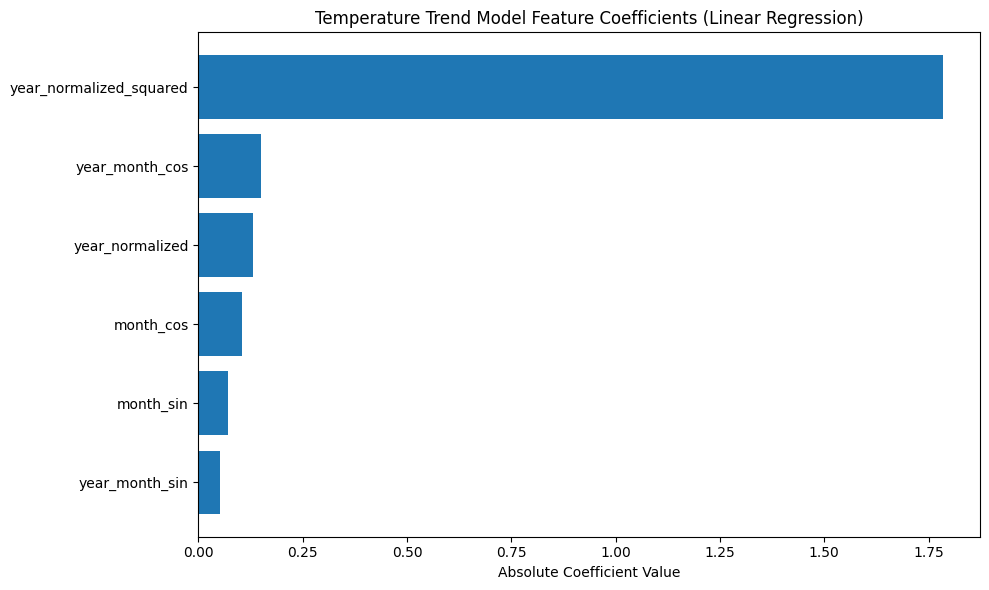


=== TEMPERATURE TREND MODEL COEFFICIENTS (time features) ===
                   feature  coefficient  abs_coefficient
1  year_normalized_squared     1.784120         1.784120
5           year_month_cos     0.150215         0.150215
0          year_normalized    -0.129751         0.129751
3                month_cos    -0.103434         0.103434
2                month_sin     0.070549         0.070549
4           year_month_sin    -0.050992         0.050992


In [23]:
# Temperature residual model feature importances and trend coefficients

# Residual (GB) feature importances
temp_residual_feature_importances = pd.DataFrame({
    'feature': X_temp_residual_train.columns,
    'importance': residual_temp_model_gb.feature_importances_,
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(range(len(temp_residual_feature_importances)), temp_residual_feature_importances['importance'])
plt.yticks(range(len(temp_residual_feature_importances)), temp_residual_feature_importances['feature'])
plt.xlabel('Feature Importance')
plt.title('Temperature Residual Model Feature Importances (Gradient Boosting)')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig('temp_model/images/temp_residual_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 10 most important temperature residual features:")
print(temp_residual_feature_importances.head(10))

# Temperature trend model coefficients (similar to CO₂)
trend_temp_coefficients = pd.DataFrame({
    'feature': trend_temp_features,
    'coefficient': trend_temp_model.coef_,
    'abs_coefficient': np.abs(trend_temp_model.coef_),
}).sort_values('abs_coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(range(len(trend_temp_coefficients)), trend_temp_coefficients['abs_coefficient'])
plt.yticks(range(len(trend_temp_coefficients)), trend_temp_coefficients['feature'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Temperature Trend Model Feature Coefficients (Linear Regression)')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig('temp_model/images/temp_trend_model_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n=== TEMPERATURE TREND MODEL COEFFICIENTS (time features) ===")
print(trend_temp_coefficients)


In [24]:
# Save temperature trend + residual models and parameters (similar to CO2)

temp_model_dir = 'temp_model'
if not os.path.exists(temp_model_dir):
    os.mkdir(temp_model_dir)

joblib.dump(trend_temp_model, os.path.join(temp_model_dir, 'temp_trend_model.pkl'))
joblib.dump(residual_temp_model_gb, os.path.join(temp_model_dir, 'temp_residual_model_gb.pkl'))
joblib.dump({
    'bias_correction_temp': float(_bias_correction_temp),
}, os.path.join(temp_model_dir, 'temp_normalization_params.pkl'))

print("Temperature trend + residual models and parameters saved successfully.")


Temperature trend + residual models and parameters saved successfully.


In [25]:
# Register temperature trend + residual model in Hopsworks (same pattern as CO2)

# Prepare metrics dict for Hopsworks (must be numeric)
res_temp_dict = {
    'MSE': float(mse_temp),
    'R squared': float(r2_temp),
    'MAE': float(mae_temp),
    'BiasCorrection': float(_bias_correction_temp),
}

temp_model_description = "TemperatureTrend + GBResidual + BiasCorrection"

mr = project.get_model_registry()

temp_model_name = "global_temperature_trend_residual_model"
print(f"Creating temperature model: {temp_model_name}")

temp_model = mr.python.create_model(
    name=temp_model_name,
    metrics=res_temp_dict,
    feature_view=temp_feature_view,
    description=f"Global temperature anomaly predictor using {temp_model_description}",
)

# Save artifacts into the 'temp_model' directory in the model registry
temp_model.save(temp_model_dir)
print("Temperature trend + residual model registered successfully in Hopsworks.")


Creating temperature model: global_temperature_trend_residual_model


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/datskiw/KTH/ID2223/project/atwEarthTamagotchi/notebooks/temp_model/temp_normalization_params.…

Uploading /Users/datskiw/KTH/ID2223/project/atwEarthTamagotchi/notebooks/temp_model/temp_trend_model.pkl: 0.00…

Uploading /Users/datskiw/KTH/ID2223/project/atwEarthTamagotchi/notebooks/temp_model/temp_residual_model_gb.pkl…

Uploading /Users/datskiw/KTH/ID2223/project/atwEarthTamagotchi/notebooks/temp_model/images/temp_trend_model_co…

Uploading /Users/datskiw/KTH/ID2223/project/atwEarthTamagotchi/notebooks/temp_model/images/temp_residual_featu…

Uploading /Users/datskiw/KTH/ID2223/project/atwEarthTamagotchi/notebooks/temp_model/images/temp_hindcast.png: …

Uploading /Users/datskiw/KTH/ID2223/project/atwEarthTamagotchi/notebooks/model_schema.json: 0.000%|          |…

Model created, explore it at https://eu-west.cloud.hopsworks.ai:443/p/2177/models/global_temperature_trend_residual_model/3
Temperature trend + residual model registered successfully in Hopsworks.
